# How to do per-user retrieval

This guide demonstrates how to configure runtime properties of a retrieval chain. An example application is to limit the documents available to a [retriever](/docs/concepts/retrievers/) based on the user.

When building a [retrieval app](/docs/concepts/rag/), you often have to build it with multiple users in mind. This means that you may be storing data not just for one user, but for many different users, and they should not be able to see eachother's data. This means that you need to be able to configure your retrieval chain to only retrieve certain information. This generally involves two steps.

**Step 1: Make sure the retriever you are using supports multiple users**

At the moment, there is no unified flag or filter for this in LangChain. Rather, each vectorstore and retriever may have their own, and may be called different things (namespaces, multi-tenancy, etc). For vectorstores, this is generally exposed as a keyword argument that is passed in during `similarity_search`. By reading the documentation or source code, figure out whether the retriever you are using supports multiple users, and, if so, how to use it.

Note: adding documentation and/or support for multiple users for retrievers that do not support it (or document it) is a GREAT way to contribute to LangChain

**Step 2: Add that parameter as a configurable field for the chain**

This will let you easily call the chain and configure any relevant flags at runtime. See [this documentation](/docs/how_to/configure) for more information on configuration.

Now, at runtime you can call this chain with configurable field.

## Code Example

Let's see a concrete example of what this looks like in code. We will use Pinecone for this example.

To configure Pinecone, set the following environment variable:

- `PINECONE_API_KEY`: Your Pinecone API key

In [2]:
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore

embeddings = OpenAIEmbeddings()
vectorstore = PineconeVectorStore(index_name="test-example", embedding=embeddings)

vectorstore.add_texts(["I worked at Kensho"], namespace="harrison")
vectorstore.add_texts(["I worked at Facebook"], namespace="ankush")

['f907aab7-77c7-4347-acc2-6859f8142f92']

The pinecone kwarg for `namespace` can be used to separate documents

In [4]:
# This will only get documents for Ankush
vectorstore.as_retriever(search_kwargs={"namespace": "ankush"}).invoke(
    "where did i work?"
)

[Document(id='f907aab7-77c7-4347-acc2-6859f8142f92', metadata={}, page_content='I worked at Facebook')]

In [5]:
# This will only get documents for Harrison
vectorstore.as_retriever(search_kwargs={"namespace": "harrison"}).invoke(
    "where did i work?"
)

[Document(id='16061fc5-c6fc-4f45-a3b3-23469d7996af', metadata={}, page_content='I worked at Kensho')]

We can now create the chain that we will use to do question-answering over.

Let's first select a LLM.

import ChatModelTabs from "@theme/ChatModelTabs";

<ChatModelTabs customVarName="llm" />


In [6]:
# | output: false
# | echo: false

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

This will follow the basic implementation from the [RAG tutorial](/docs/tutorials/rag), but we will allow the retrieval step to be configurable.

In [7]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import ConfigurableField

template = """Answer the question based only on the following context:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

retriever = vectorstore.as_retriever()

Here we mark the retriever as having a configurable field. All vectorstore retrievers have `search_kwargs` as a field. This is just a dictionary, with vectorstore specific fields.

This will let us pass in a value for `search_kwargs` when invoking the chain.

In [8]:
configurable_retriever = retriever.configurable_fields(
    search_kwargs=ConfigurableField(
        id="search_kwargs",
        name="Search Kwargs",
        description="The search kwargs to use",
    )
)

We can now create the chain using our configurable retriever.

In [9]:
from langchain_core.documents import Document
from langchain_core.runnables import RunnableConfig
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# highlight-next-line
def retrieve(state: State, config: RunnableConfig):
    # highlight-next-line
    retrieved_docs = configurable_retriever.invoke(state["question"], config)
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

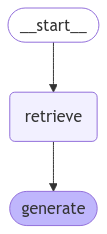

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

We can now invoke the chain with configurable options. `search_kwargs` is the id of the configurable field. The value is the search kwargs to use for Pinecone.

In [13]:
result = graph.invoke(
    {"question": "Where did the user work?"},
    config={"configurable": {"search_kwargs": {"namespace": "harrison"}}},
)

result

{'question': 'Where did the user work?',
 'context': [Document(id='16061fc5-c6fc-4f45-a3b3-23469d7996af', metadata={}, page_content='I worked at Kensho')],
 'answer': 'The user worked at Kensho.'}

In [14]:
result = graph.invoke(
    {"question": "Where did the user work?"},
    config={"configurable": {"search_kwargs": {"namespace": "ankush"}}},
)

result

{'question': 'Where did the user work?',
 'context': [Document(id='f907aab7-77c7-4347-acc2-6859f8142f92', metadata={}, page_content='I worked at Facebook')],
 'answer': 'The user worked at Facebook.'}

For details operating your specific vector store, see the [integration pages](/docs/integrations/vectorstores/).